# **PRÁCTICA 2: AUTOENCODERS - Parte 2: Convolucionales**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos

## **Ejercicio 1: Comprueba la reconstrucción**

### Autoencoder convolucional

**Codificador automático convolucional**

<p align="justify">Dado que nuestras entradas son imágenes, tiene sentido utilizar redes neuronales convolucionales (convnets) como codificadores y decodificadores. En entornos prácticos, los codificadores automáticos aplicados a las imágenes son siempre codificadores automáticos convolucionales, simplemente funcionan mucho mejor.</p>

<p align="justify">Implementemos uno. El codificador consistirá en una pila de capas Conv2Dy MaxPooling2D(la agrupación máxima se utiliza para el muestreo descendente espacial), mientras que el decodificador consistirá en una pila de capas Conv2Dy .UpSampling2D.</p>

<p align="justify">Es decir, comenzaremos de manera simple, con una sola capa neuronal completamente conectada como codificador y decodificador:</p>

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
# MODELO

# ENCODER activity_regularizer (parámentro de las Dense); activity_regularizer = regularizers.l1(0.01)
input_img = Input(shape=(28, 28, 1))  
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# DECODER
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


In [4]:
opt = Adam(learning_rate=0.0001)
autoencoder0 = Model(input_img, decoded)
autoencoder0.compile(optimizer=opt, loss='mse')

In [5]:
autoencoder0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

<p align="justify">Para entrenarlo, usaremos los dígitos MNIST originales:</p>

In [6]:
# DATOS
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

11490434/11490434 [==============================] - 0s 0us/step


<p align="justify">Entrenemos este modelo durante 100 épocas.</p>

In [7]:
# ENTRENAMIENTO
from keras.callbacks import TensorBoard

autoencoder0.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/100
469/469 [==============================] - 12s 7ms/step - loss: 0.1167 - val_loss: 0.0579
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0491 - val_loss: 0.0433
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0406 - val_loss: 0.0375
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0356 - val_loss: 0.0332
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0319 - val_loss: 0.0300
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0289 - val_loss: 0.0274
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0267 - val_loss: 0.0255
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0251 - val_loss: 0.0242
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0238 - val_loss: 0.0230
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0228 - val_l

<p align="justify">Después de 100 épocas, el codificador automático parece alcanzar un valor de pérdida de validación/entrenamiento estable de aproximadamente 0.0122. Podemos intentar visualizar las entradas reconstruidas y las representaciones codificadas. Usaremos Matplotlib en el siguiente apartado.</p>

<p align="justify">Echemos un vistazo a los dígitos reconstruidos.</p>

313/313 [==============================] - 1s 2ms/step
Imágenes originales


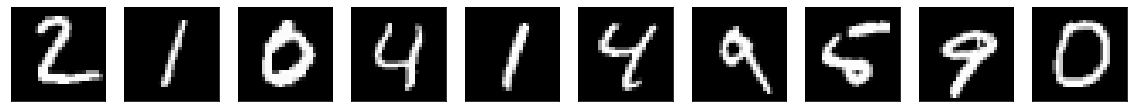

Reconstrucción (salida del decoder):


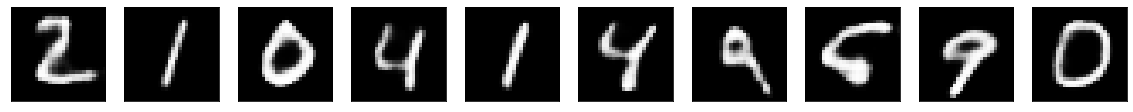

In [8]:
import matplotlib.pyplot as plt
n=10
decoded_imgs0 = autoencoder0.predict(x_test)

plt.figure(figsize=(20, 4))
print("Imágenes originales")
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 4))
print("Reconstrucción (salida del decoder):")
for i in range(1, n + 1):
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs0[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<p align="justify">Esto es lo que obtenemos. La fila superior son los dígitos originales y la fila inferior son los dígitos reconstruidos.</p>

<p align="justify">También podemos echar un vistazo a las representaciones codificadas de 128 dimensiones. Estas representaciones son 8x4x4, por lo que las remodelamos a 4x32 para poder mostrarlas como imágenes en escala de grises.</p>

313/313 [==============================] - 1s 2ms/step


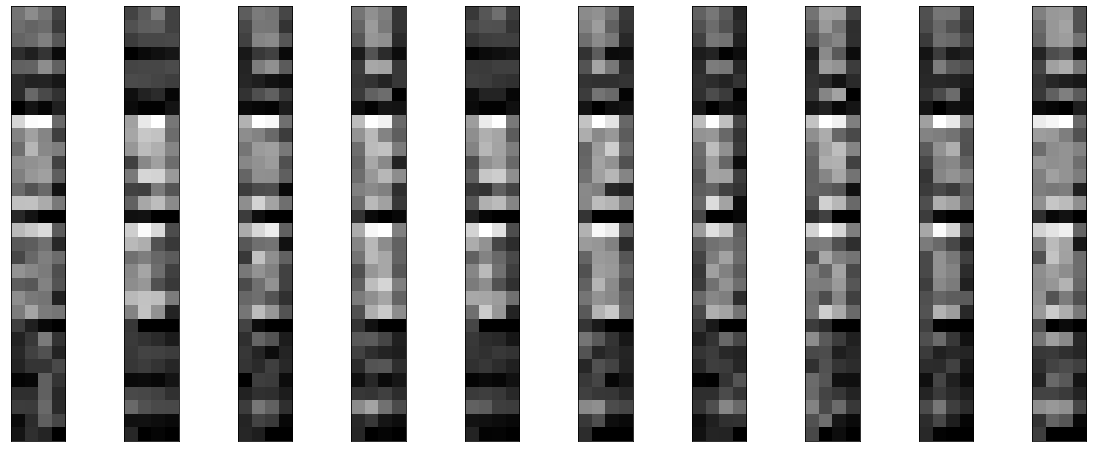

In [9]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()